In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib.font_manager as fm
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우

plt.rc('axes', unicode_minus=False)  # 마이너스 깨짐 방지

In [69]:
df = pd.read_csv('./data/merge_data.csv')
df.head(2)

,nickname,world_name,character_class,character_level,character_exp_rate,character_date_create,dojang_best_floor,dojang_best_time,popularity,최소 스탯공격력,...,상태이상 추가 데미지,무기 숙련도,추가 경험치 획득,공격력,마력,전투력,소환수 지속시간 증가,force_sum,force_mean,force_min
0,아델,스카니아,아델,292,47.568,2020-01-16T00:00+09:00,99,896,8778,373904068,...,14.0,90,195.0,19129,4232,1352790435,10,2080.0,160.0,100.0
1,흡혈,스카니아,데몬어벤져,285,70.911,2022-03-30T00:00+09:00,85,884,595,271680490,...,14.0,90,59.0,14009,3710,1184547868,10,1950.0,150.0,0.0


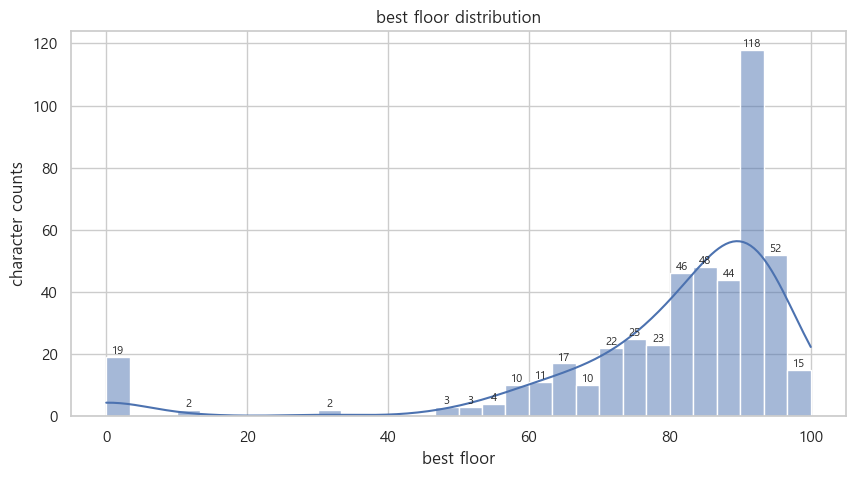

In [70]:
# 도장 최고층수 기본 분포 확인
plt.figure(figsize=(10,5))
ax = sns.histplot(df['dojang_best_floor'], bins=30, kde=True)

# 각 bar에 캐릭터 수 표시
for i in ax.patches:
    count = int(i.get_height())
    if count > 0 :
        ax.annotate(f'{count}', (i.get_x() + i.get_width() / 2, count),
                    ha='center', va='bottom', fontsize=8, rotation=0)
        
plt.title('best floor distribution')
plt.xlabel('best floor')
plt.ylabel('character counts')
plt.grid(True)
plt.show()

In [71]:
# 직업별 도장 최고층수 분포

# 직업별 평균 도장 최고층수 계산 후 시각화

mean_floor_by_class = (
    df.groupby('character_class')['dojang_best_floor']
    .mean()
    .sort_values(ascending=False)
)

# 상위 10개 하위 10개 직업을 시각화 해보기

C:\Users\user\AppData\Local\Temp\ipykernel_36832\2879527422.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_floor_by_class.head(10).index, y=mean_floor_by_class.head(10).values, palette=palette)


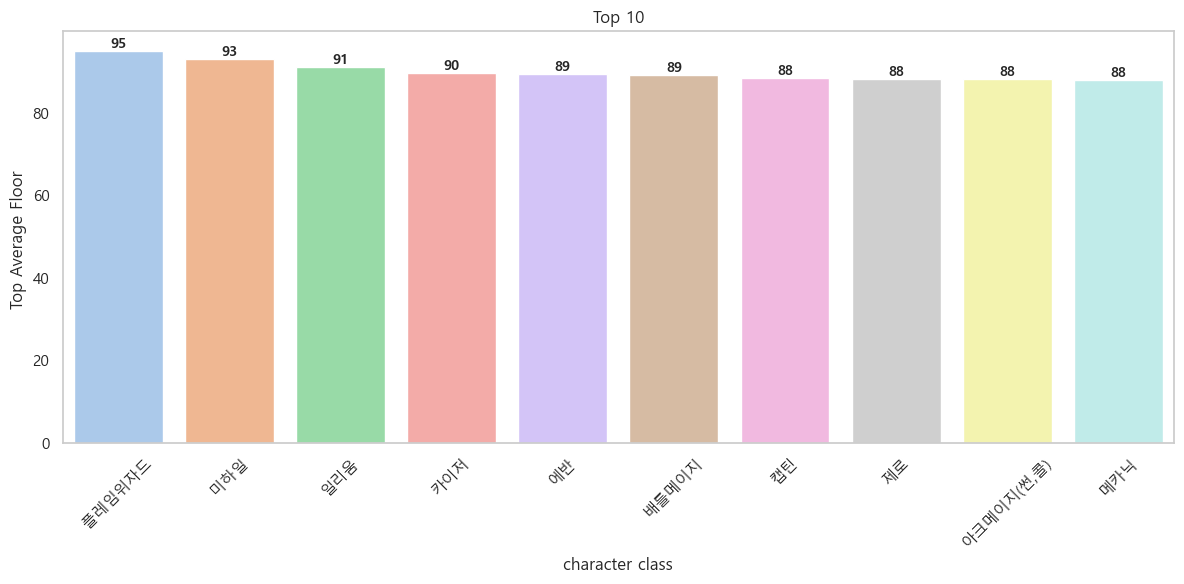

In [72]:
# 우선 상위 10개
palette = sns.color_palette("pastel")
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_floor_by_class.head(10).index, y=mean_floor_by_class.head(10).values, palette=palette)

for p in ax.patches:
    value = int(round(p.get_height()))
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Top 10')
plt.xlabel('character class')
plt.ylabel('Top Average Floor ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_36832\1422059787.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_floor_by_class.tail(10).index, y=mean_floor_by_class.tail(10).values, palette=palette)


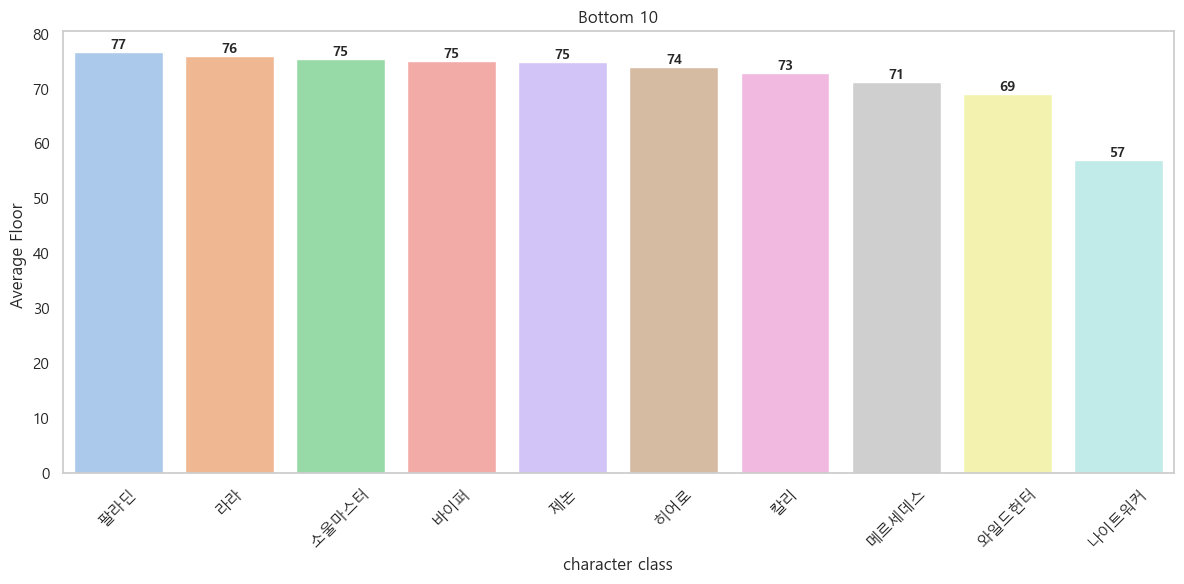

In [73]:
# 하위 10개 직업
# 4번 라인 head만 tail로 바꿔주면 끝

palette = sns.color_palette("pastel")
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_floor_by_class.tail(10).index, y=mean_floor_by_class.tail(10).values, palette=palette)

for p in ax.patches:
    value = int(round(p.get_height()))
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Bottom 10')
plt.xlabel('character class')
plt.ylabel('Average Floor ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [74]:
df = df.drop(['character_date_create','nickname','world_name'], axis=1)
len(df['character_class'].value_counts())

44

In [75]:
# 우선 직업이 무려 44개나 됨 이걸 이후에 머신러닝 feature로 활용하기 위한 작업이 필요함
# 더미변수로 작업할 경우 컬럼이 44개나 더 생기는데, 이는 과적합을 발생시킬 위험이 존재
# 따리서 label encoding을 통해 숫자로 변환한 후, object type으로 변경

# 1. 고유한 직업 리스트 먼저 추출
unique_classes = df['character_class'].drop_duplicates().sort_values().reset_index(drop=True)

# 2. LabelEncoder 적용
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
class_mapping = pd.DataFrame({
    'character_class': unique_classes,
    'character_class_encoded': le.fit_transform(unique_classes)
})

class_mapping.to_csv('./data/class_mapping.csv', index=False)

# 3. 이후 df에 인코딩 값 부여
df = df.merge(class_mapping, on='character_class', how='left')


In [76]:
# 캐릭터 직업(character_class)컬럼 지우기

df = df.drop('character_class',axis=1)

In [77]:
df.columns

Index(['character_level', 'character_exp_rate', 'dojang_best_floor',
       'dojang_best_time', 'popularity', '최소 스탯공격력', '최대 스탯공격력', '데미지',
       '보스 몬스터 데미지', '최종 데미지', '방어율 무시', '크리티컬 확률', '크리티컬 데미지', '상태이상 내성',
       '스탠스', '방어력', '이동속도', '점프력', '스타포스', '아케인포스', '어센틱포스', 'STR', 'DEX',
       'INT', 'LUK', 'HP', 'MP', 'AP 배분 STR', 'AP 배분 DEX', 'AP 배분 INT',
       'AP 배분 LUK', 'AP 배분 HP', 'AP 배분 MP', '아이템 드롭률', '메소 획득량', '버프 지속시간',
       '공격 속도', '일반 몬스터 데미지', '재사용 대기시간 감소 (초)', '재사용 대기시간 감소 (%)',
       '재사용 대기시간 미적용', '속성 내성 무시', '상태이상 추가 데미지', '무기 숙련도', '추가 경험치 획득', '공격력',
       '마력', '전투력', '소환수 지속시간 증가', 'force_sum', 'force_mean', 'force_min',
       'character_class_encoded'],
      dtype='object')

In [78]:
# Drop columns
# 스탠스 : 고윳값이 하나
# 점프력 : 고윳값이 하나
# AP 배분 능력치 : 자동배분임 도장 순위에는 STR, DEX, INT, LUK 을 중점적으로 보는게 좋을듯

In [80]:
# 위의 세가지(고윳값이 하나인 컬럼 제거)
df.drop(columns=['스탠스','점프력','AP 배분 STR', 'AP 배분 DEX', 'AP 배분 INT',
       'AP 배분 LUK', 'AP 배분 HP', 'AP 배분 MP'], inplace=True)

### 캐릭터 성장 관련 피처 분포 시각화 및 전처리

- character_level
- character_exp_rate
- popularity
- 스타포스
- 아케인포스
- 어센틱포스

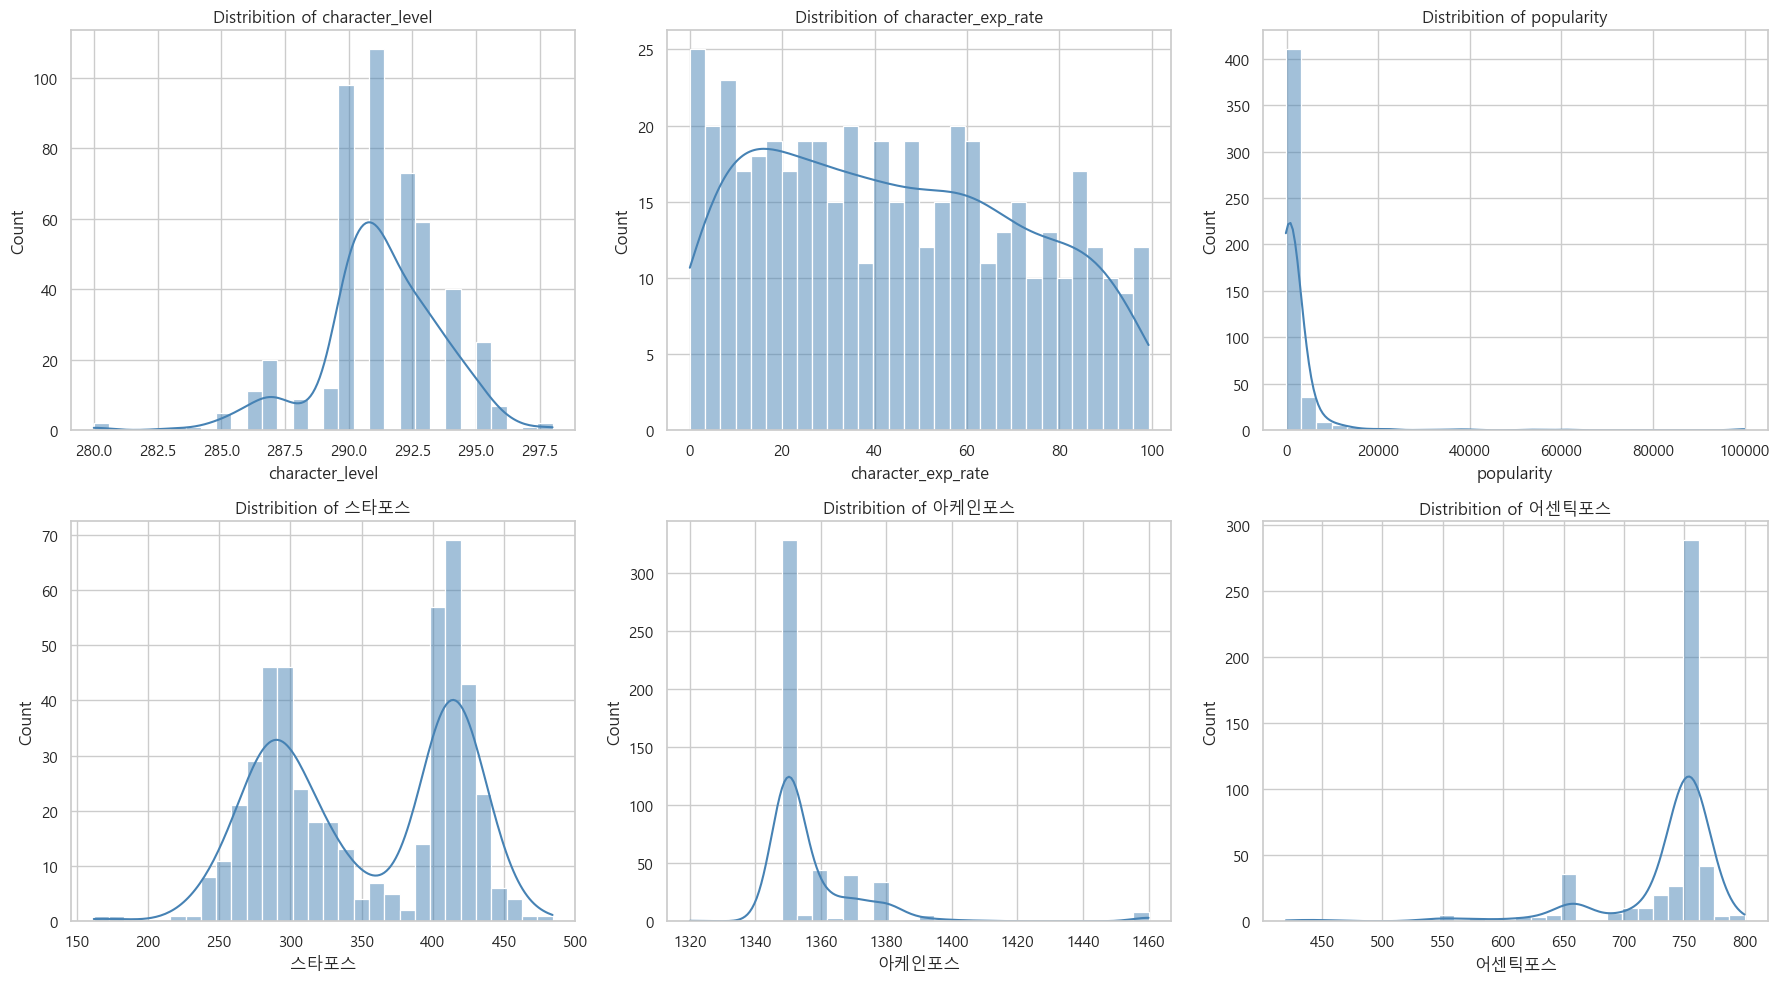

In [81]:
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False  

growth_feature = ['character_level','character_exp_rate','popularity'
                  ,'스타포스','아케인포스','어센틱포스']

fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()

for i, col in enumerate(growth_feature):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='steelblue')
    axes[i].set_title(f'Distribition of {col}', fontsize=12)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

1. character_level
    - 분포 : 대~체로 정규분포스럽(?)긴 함
    - 이상치는 없음(있을수가 없긴함 랭커들을 크롤링해서 한것이니)

2. character_exp_rate
    - 분포 :  전 범위에 고르게 분포
    - 0~1 로 정규화 (MinMaxScale)

3. Popularity
    - 분포 : 극단적인 이상치가 존재함. - 물론 인기도의 척도는 유명 방송인이 압도적일것이라 어느정도 예상은 함
    - 과연 인기도가 무릉도장 등수에 영향을 미치는가...?에 대해서는 조금 궁금하긴함
    - <span style="color:orange">**통계분석만을 진행해볼 것(spearmanr, pearsonr)**</span>
    - <span style="color:orange">**ML input feature 에선 제거**</span>

4. 스타포스
    - 분포 : 봉우리가 두개임 재밋게 생김(두개의 집단으로 나뉨)
    - 제법 유의미한 데이터가 될 것 같은 느낌임
    - 그대로 사용해도 괜찮을것 같음

5. 아케인포스
    - 스읍....아무래도 고랩 유저다 보면 아케인포스 관리는 꾸준할테니,,
    - 유의미해 보이진 않음
    - <span style="color:orange">**제거**</span>

6. 어센틱 포스
    - 얘도 <span style="color:orange">**제거**</span>

In [82]:
# popularity 가 과연 target으로 두고 있는 dojang_best_floor랑 어떤 관계에 있는가에 대하여

from scipy.stats import spearmanr, pearsonr

tmp_df = df[['popularity', 'dojang_best_floor']].dropna()

# Spearman
spearman_corr, spearman_p = spearmanr(tmp_df['popularity'], tmp_df['dojang_best_floor'])

# Pearson
pearson_corr, pearson_p = pearsonr(tmp_df['popularity'], tmp_df['dojang_best_floor'])

print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

Spearman correlation: 0.2131, p-value: 0.0000
Pearson correlation: -0.0539, p-value: 0.2416


- 결과가 뭔가 좀 애매한것이...(물론 유의미한건 아님 제거해도 무방하긴함) 인기도 자체가 최고층수에 대해서는 의미가 아예 없지는 않다고 해석됨
- 물론 목적으로 두고있는 도장층수 예측에는 활용은 안할듯 하지만, 인기도가 도장 층수에 대해 후천적으로 작용하는 부분은 있다고도 할 수 있을듯.

In [83]:
# 1. character_exp_rate : 0~1 비율로 정규화
df['character_exp_rate'] = df['character_exp_rate']/100

# 2. 아케인 어센틱 제거
df.drop(columns=['아케인포스','어센틱포스','popularity'], inplace=True)

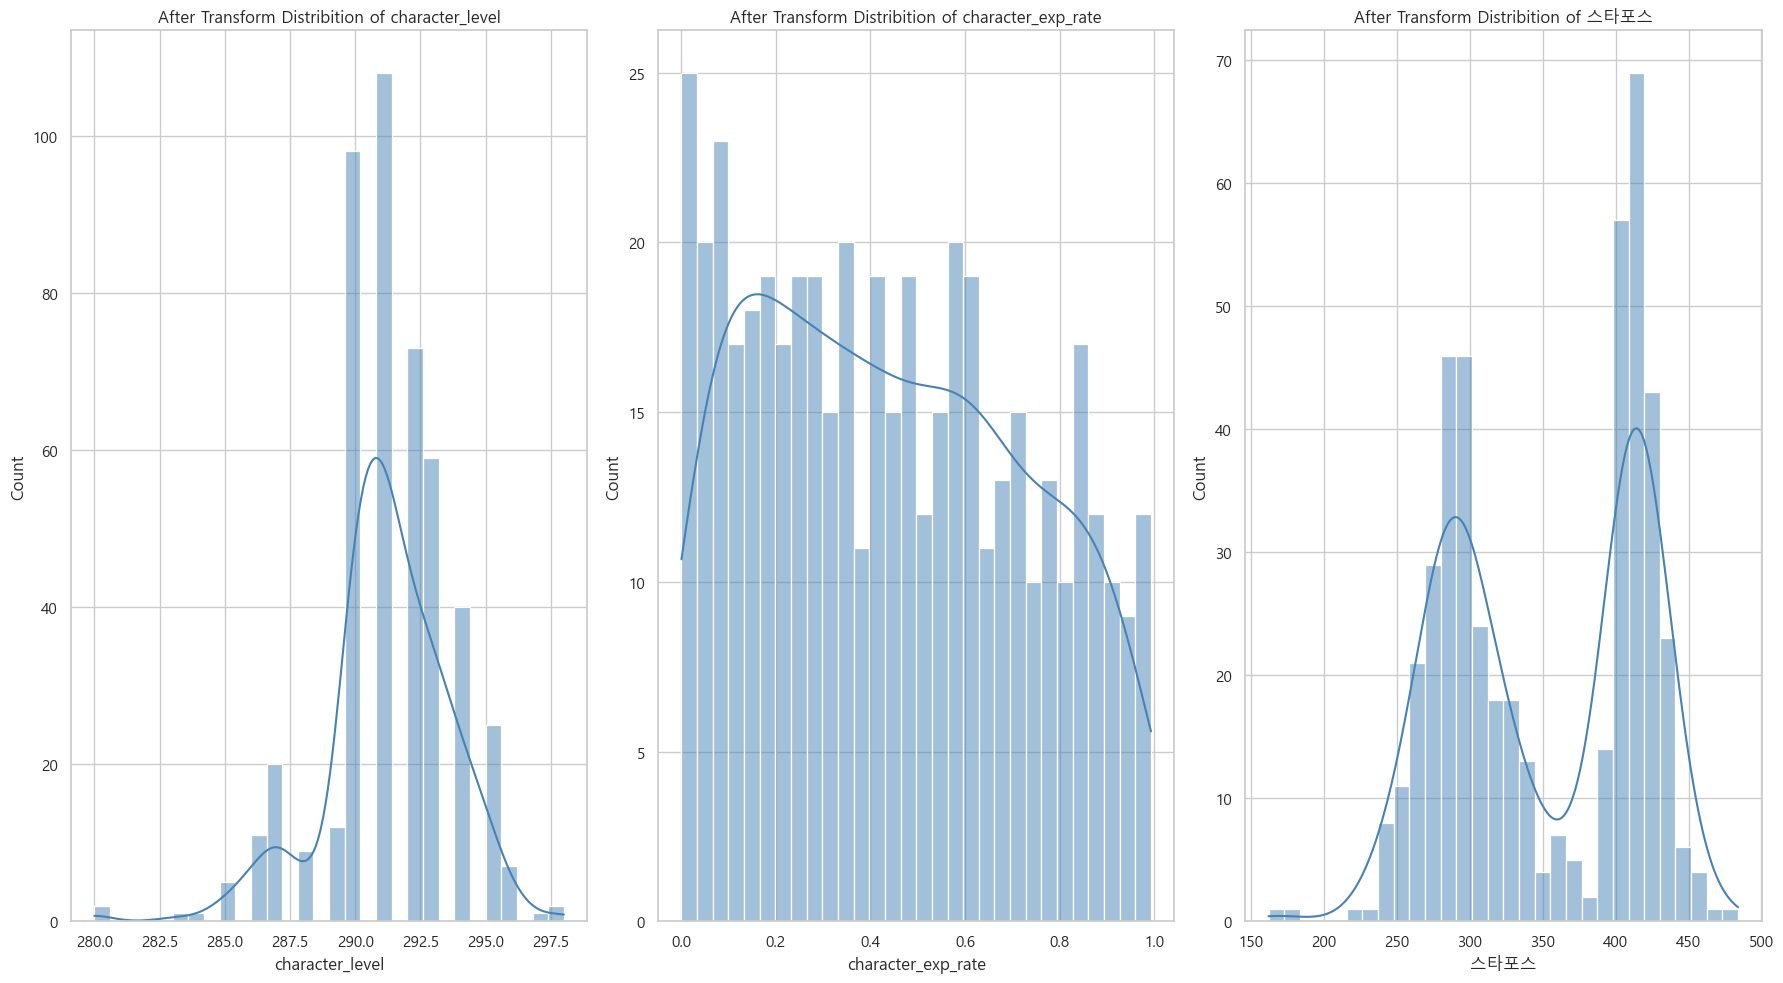

In [84]:
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False  

growth_feature = ['character_level','character_exp_rate','스타포스']

fig, axes = plt.subplots(1, 3, figsize=(18,10))
axes = axes.flatten()

for i, col in enumerate(growth_feature):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='steelblue')
    axes[i].set_title(f'After Transform Distribition of {col}', fontsize=12)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

### 공격력 관련 Features

1. 최소 스탯공격력
2. 최대 스탯공격력
3. 공격력
4. 마력
5. 전투력

In [90]:
df.columns

Index(['character_level', 'character_exp_rate', 'dojang_best_floor',
       'dojang_best_time', '최소 스탯공격력', '최대 스탯공격력', '데미지', '보스 몬스터 데미지',
       '최종 데미지', '방어율 무시', '크리티컬 확률', '크리티컬 데미지', '상태이상 내성', '방어력', '이동속도',
       '스타포스', 'STR', 'DEX', 'INT', 'LUK', 'HP', 'MP', '아이템 드롭률', '메소 획득량',
       '버프 지속시간', '공격 속도', '일반 몬스터 데미지', '재사용 대기시간 감소 (초)', '재사용 대기시간 감소 (%)',
       '재사용 대기시간 미적용', '속성 내성 무시', '상태이상 추가 데미지', '무기 숙련도', '추가 경험치 획득', '공격력',
       '마력', '전투력', '소환수 지속시간 증가', 'force_sum', 'force_mean', 'force_min',
       'character_class_encoded'],
      dtype='object')

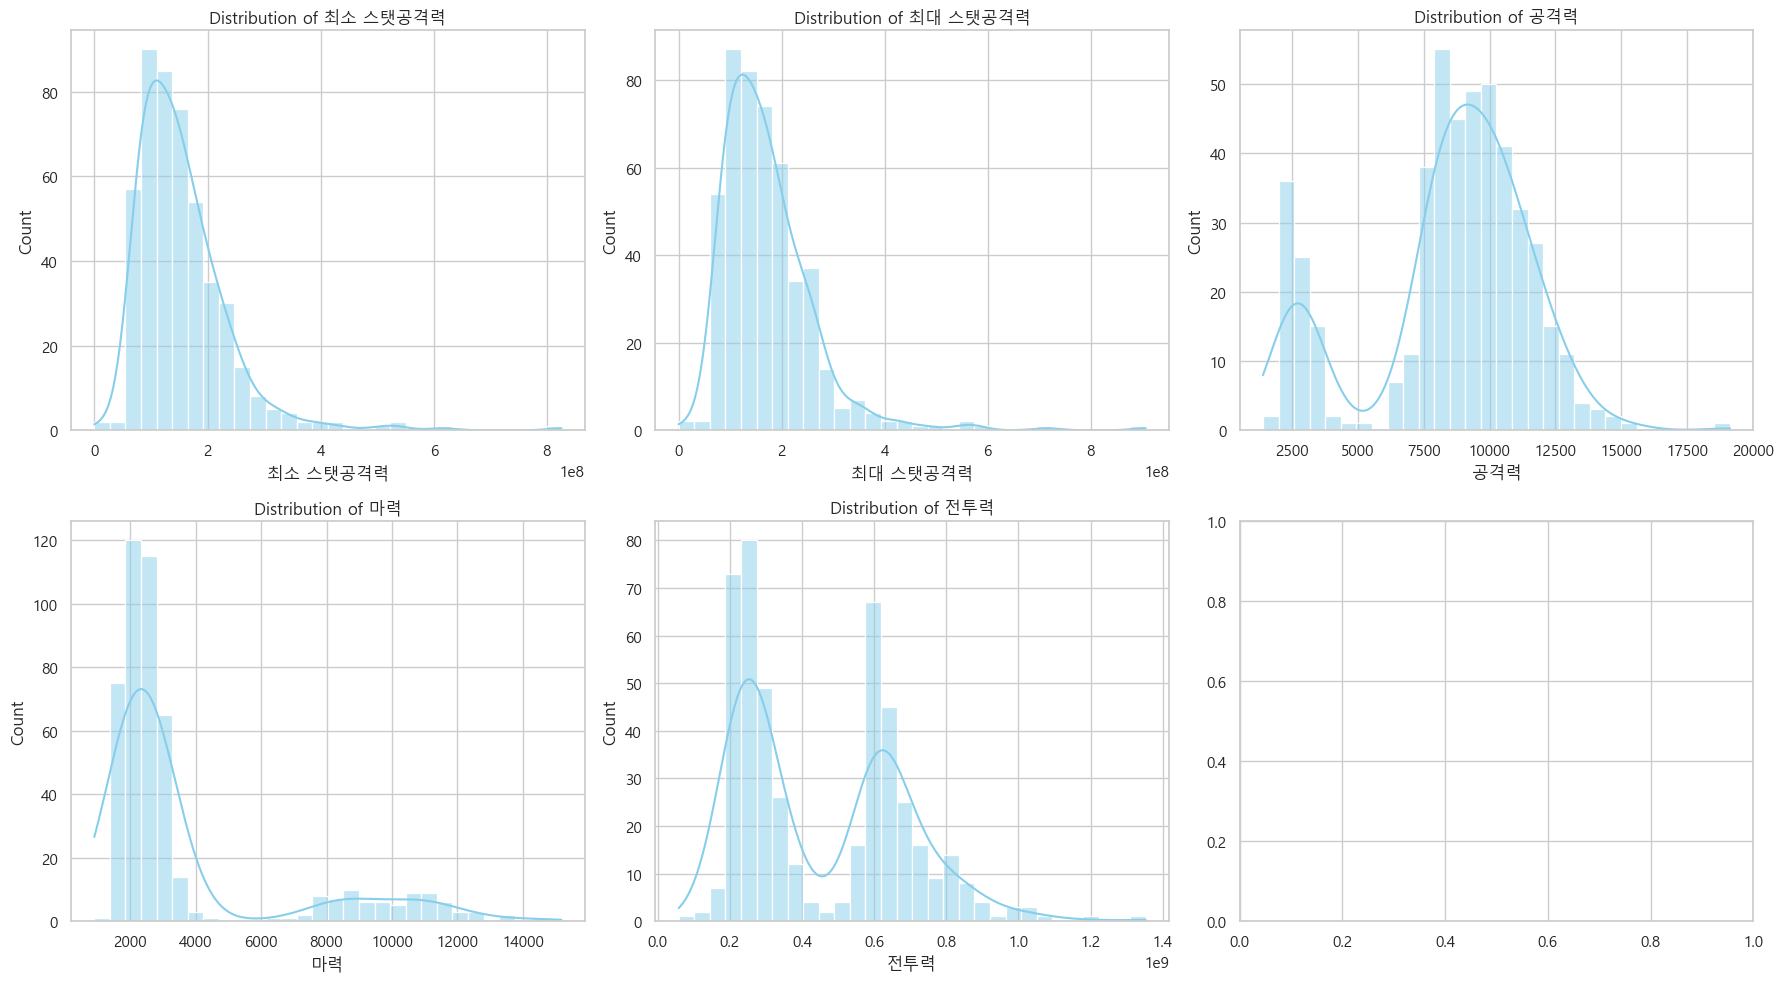

In [93]:
cols = ['최소 스탯공격력','최대 스탯공격력','공격력','마력','전투력']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], kde = True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

- 그림이 이전 분석 컬럼보단 확실히 이쁨(제법 정규성을 보이는듯한 느낌)

- 다섯개의 컬럼 변환 방법
    - 최소 스탯공격력 -> 오른쪽 치우침 : log transform

    - 최대 스탯공격력 -> '최소 스탯공격력' 이랑 마찬가지

    - 공격력 : 그냥 냅둬도 될듯 이후 머신러닝 성능에 따라 정규화를 할지 고민

    - 마력 : 얘도 log 변환 (치움침이 강해서)
    
    - 전투력 : 얘는 억단위 스케일이라 log변환 꼭 해야함 ㅎㅎ

In [97]:
df['최소 스탯공격력'] = np.log1p(df['최소 스탯공격력'])
df['최대 스탯공격력'] = np.log1p(df['최대 스탯공격력'])
df['마력'] = np.log1p(df['마력'])
df['전투력'] = np.log1p(df['전투력'])

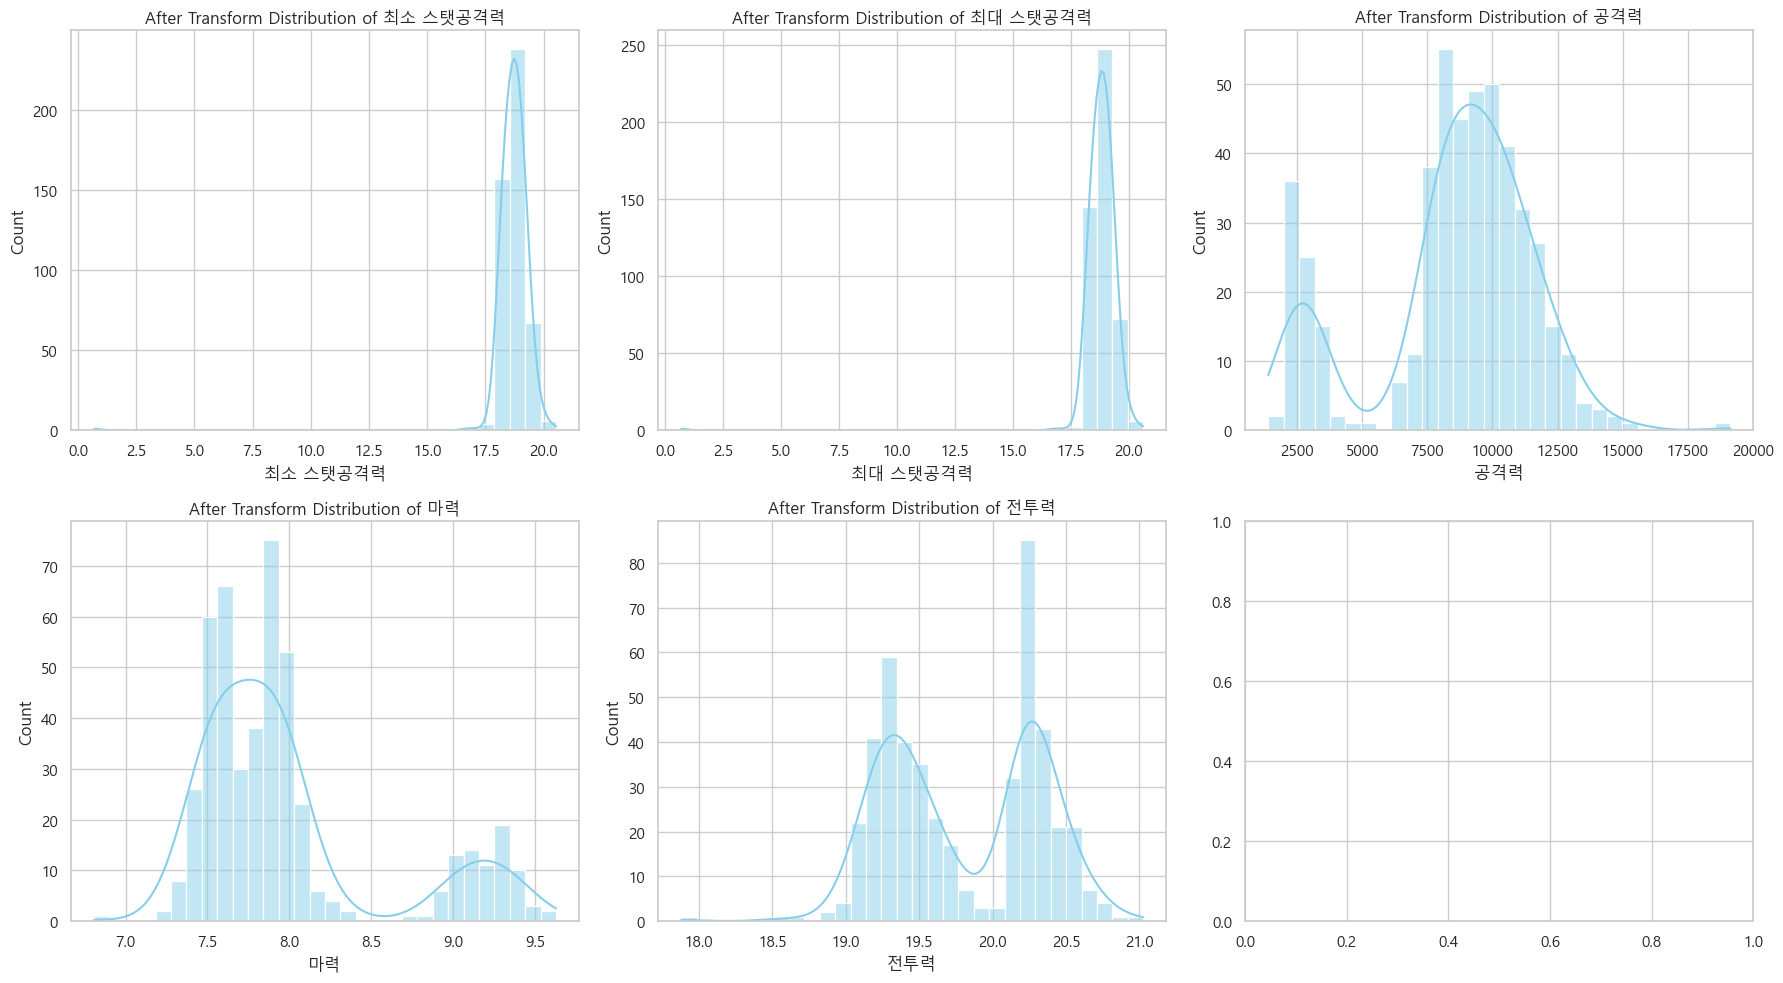

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], kde = True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'After Transform Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()